In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors


## Define Grid World Parameters
Creates a n by n grid, sets start/goal positions, adds fixed walls, and randomizes hazard cells each run.

In [26]:
# Grid dimensions
n_rows, n_cols = 10, 10   #You can freely change these numbers

# Start and Goal positions
START = (0, 0)
GOAL = (n_rows - 1, n_cols - 1)

WALLS = set()

# Random hazards (different each run unless seeded)
HAZARD_COUNT = 35
HAZARD_PENALTY_OPTIONS = [-2.0, -4.0, -6.0]
HAZARD_SEED = None  # set integer for reproducible hazards

def generate_random_hazards(count=HAZARD_COUNT, seed=HAZARD_SEED):
    rng = np.random.default_rng(seed)
    forbidden = {START, GOAL} | WALLS
    candidates = [(r, c) for r in range(n_rows) for c in range(n_cols) if (r, c) not in forbidden]
    rng.shuffle(candidates)
    chosen = candidates[:count]
    return {cell: float(rng.choice(HAZARD_PENALTY_OPTIONS)) for cell in chosen}

HAZARDS = generate_random_hazards()

# Display setup summary
print(f"Grid size: {n_rows}x{n_cols}")
print(f"Start: {START} | Goal: {GOAL}")
print(f"Walls ({len(WALLS)}): {WALLS}")
print(f"Hazards ({len(HAZARDS)}): {HAZARDS}")



Grid size: 10x10
Start: (0, 0) | Goal: (9, 9)
Walls (0): set()
Hazards (35): {(2, 7): -6.0, (6, 7): -2.0, (6, 2): -2.0, (5, 2): -4.0, (6, 3): -2.0, (7, 7): -6.0, (9, 2): -6.0, (1, 9): -6.0, (8, 2): -4.0, (7, 4): -4.0, (8, 1): -2.0, (4, 3): -6.0, (3, 1): -6.0, (7, 8): -4.0, (1, 6): -4.0, (8, 4): -2.0, (9, 6): -2.0, (0, 2): -6.0, (5, 8): -4.0, (8, 3): -4.0, (3, 7): -4.0, (9, 5): -4.0, (0, 8): -2.0, (8, 5): -6.0, (9, 0): -6.0, (9, 3): -6.0, (3, 6): -2.0, (5, 0): -4.0, (2, 6): -2.0, (1, 5): -2.0, (0, 9): -4.0, (6, 4): -6.0, (4, 0): -2.0, (4, 2): -2.0, (2, 3): -2.0}


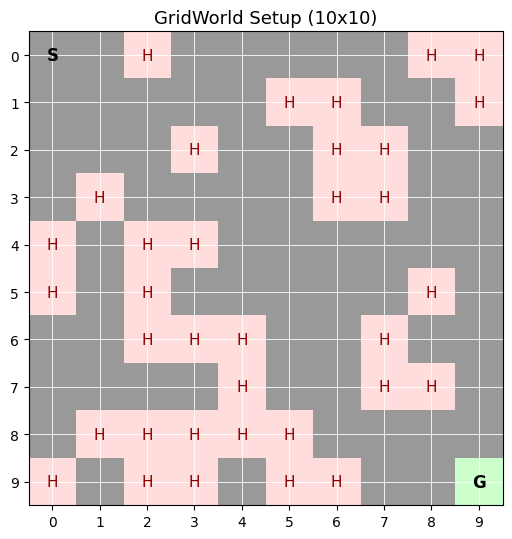

In [27]:
# Grid Setup Visualization

import matplotlib.pyplot as plt
from matplotlib import colors

def plot_grid_setup(n_rows, n_cols, START, GOAL, WALLS, HAZARDS):
    """Visualize the current GridWorld setup."""
    grid = np.zeros((n_rows, n_cols))

    # Assign codes for colors
    for (r, c) in HAZARDS:
        grid[r, c] = -1       # red
    for (r, c) in WALLS:
        grid[r, c] = -2       # gray
    rG, cG = GOAL
    grid[rG, cG] = 2          # green

    cmap = colors.ListedColormap(["#f2f2f2", "#fdd", "#999", "#cfc"])  # empty, hazard, wall, goal
    bounds = [-3, -1.5, -0.5, 1.5, 3]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots(figsize=(5.5, 5.5))
    ax.imshow(grid, cmap=cmap, norm=norm)

    # Annotate cells
    for r in range(n_rows):
        for c in range(n_cols):
            if (r, c) == START:
                ax.text(c, r, "S", ha="center", va="center", color="black", fontsize=12, fontweight="bold")
            elif (r, c) == GOAL:
                ax.text(c, r, "G", ha="center", va="center", color="black", fontsize=12, fontweight="bold")
            elif (r, c) in WALLS:
                ax.text(c, r, "■", ha="center", va="center", color="white", fontsize=12)
            elif (r, c) in HAZARDS:
                ax.text(c, r, "H", ha="center", va="center", color="darkred", fontsize=11)

    ax.set_title(f"GridWorld Setup ({n_rows}x{n_cols})", fontsize=13)
    ax.set_xticks(range(n_cols))
    ax.set_yticks(range(n_rows))
    ax.set_xticklabels(range(n_cols))
    ax.set_yticklabels(range(n_rows))
    ax.grid(which="both", color="white", linewidth=0.6)
    plt.tight_layout()
    plt.show()

# Run this cell to preview your environment before DP
plot_grid_setup(n_rows, n_cols, START, GOAL, WALLS, HAZARDS)


Legend for Above:
- S = Start Cell
- G = Goal Cell
- H = Hazard Cell
- Gray Cell = Safe/Regular Cell


## MDP Core Definitions:
Defines movement actions, transitions, and how rewards are calculated for each move.

In [28]:
A_UP, A_RIGHT, A_DOWN, A_LEFT = 0, 1, 2, 3
ACTIONS = [A_UP, A_RIGHT, A_DOWN, A_LEFT]
GAMMA, EPS = 0.97, 0.10
STEP_COST, GOAL_REWARD = -1.0, +10.0
TERMINAL_STATES = {GOAL}

LEFT_OF = {A_UP: A_LEFT, A_RIGHT: A_UP, A_DOWN: A_RIGHT, A_LEFT: A_DOWN}
RIGHT_OF = {A_UP: A_RIGHT, A_RIGHT: A_DOWN, A_DOWN: A_LEFT, A_LEFT: A_UP}
DELTA = {A_UP: (-1, 0), A_RIGHT: (0, 1), A_DOWN: (1, 0), A_LEFT: (0, -1)}

def rc_to_s(r, c): return r * n_cols + c
def s_to_rc(s): return divmod(s, n_cols)
def in_bounds(r, c): return 0 <= r < n_rows and 0 <= c < n_cols
def is_wall(r, c): return (r, c) in WALLS

def next_state_reward(s, a):
    r, c = s_to_rc(s)
    if (r, c) in TERMINAL_STATES: return s, 0.0, True
    dr, dc = DELTA[a]
    r2, c2 = r + dr, c + dc
    if not in_bounds(r2, c2) or is_wall(r2, c2): r2, c2 = r, c
    s2 = rc_to_s(r2, c2)
    reward = STEP_COST + (HAZARDS.get((r2, c2), 0))
    if (r2, c2) == GOAL: return s2, GOAL_REWARD, True
    return s2, reward, False


## Build Transition Model (P):
Creates a full probability table of what happens when you take each action in each state.

In [29]:
def build_transition_model():
    nS, nA = n_rows * n_cols, len(ACTIONS)
    P = [[None for _ in range(nA)] for _ in range(nS)]
    for s in range(nS):
        for a in ACTIONS:
            outcomes = []
            for (prob, aa) in [(1 - 2*EPS, a), (EPS, LEFT_OF[a]), (EPS, RIGHT_OF[a])]:
                if prob <= 0: continue
                s2, r, d = next_state_reward(s, aa)
                outcomes.append((prob, s2, r, d))
            merged = {}
            for p, s2, r, d in outcomes:
                merged.setdefault(s2, [0, 0, d])
                merged[s2][0] += p
                merged[s2][1] += p*r
                merged[s2][2] |= d
            P[s][a] = [(p, s2, pr/p, d) for s2, (p, pr, d) in merged.items()]
    return P

P = build_transition_model()


## Dynamic Programming Functions:
Implements Policy Evaluation, Greedy Policy Extraction, Policy Iteration, and Value Iteration.

In [30]:
def policy_evaluation(pi, P, gamma=GAMMA, theta=1e-8):
    V = np.zeros(n_rows*n_cols)
    while True:
        delta = 0
        for s in range(len(V)):
            if s_to_rc(s) in TERMINAL_STATES: continue
            v_old = V[s]
            V[s] = sum(pi[s, a] * sum(p * (r + gamma * V[s2]) for p, s2, r, d in P[s][a])
                       for a in ACTIONS)
            delta = max(delta, abs(v_old - V[s]))
        if delta < theta: break
    return V

def greedy_policy_from_V(V, P, gamma=GAMMA):
    nS, nA = n_rows*n_cols, len(ACTIONS)
    pi = np.zeros((nS, nA))
    for s in range(nS):
        if s_to_rc(s) in TERMINAL_STATES: pi[s, 0] = 1; continue
        q = [sum(p * (r + gamma * V[s2]) for p, s2, r, d in P[s][a]) for a in ACTIONS]
        pi[s, np.argmax(q)] = 1
    return pi

def value_iteration(P, gamma=GAMMA, theta=1e-8, max_iter=100000):
    V = np.zeros(n_rows*n_cols); deltas = []
    for _ in range(max_iter):
        delta = 0
        for s in range(len(V)):
            if s_to_rc(s) in TERMINAL_STATES: continue
            v_old = V[s]
            q = [sum(p * (r + gamma * V[s2]) for p, s2, r, d in P[s][a]) for a in ACTIONS]
            V[s] = max(q)
            delta = max(delta, abs(v_old - V[s]))
        deltas.append(delta)
        if delta < theta: break
    return greedy_policy_from_V(V, P), V, deltas


## Simulation (Rollout):
Run a sample episode to see a realistic path (with random slip) from Start to Goal

In [31]:
def _pick_action_from_policy(pi_arr, s):
    # pi_arr: (nS,nA) or (nS,)
    if pi_arr.ndim == 2:
        return int(np.argmax(pi_arr[s]))
    elif pi_arr.ndim == 1:
        return int(pi_arr[s])
    else:
        raise ValueError(f"Unsupported policy shape: {pi_arr.shape}")

def _sample_outcome(outcomes, rng):
    # outcomes: [(p, s2, r, d), ...]
    probs = np.array([p for (p, *_rest) in outcomes], dtype=float)
    probs = probs / probs.sum()  # guard against tiny drift
    idx = rng.choice(len(outcomes), p=probs)
    return outcomes[idx]

def rollout(P, pi, start=START, max_steps=200, seed=0):
    rng = np.random.default_rng(seed)
    nS, nA = n_rows * n_cols, len(ACTIONS)
    pi_arr = np.asarray(pi)

    # Shape guards
    if len(P) != nS:
        raise ValueError(f"P size {len(P)} != nS {nS}. Rebuild P with build_transition_model().")
    if not ((pi_arr.ndim == 2 and pi_arr.shape == (nS, nA)) or
            (pi_arr.ndim == 1 and pi_arr.shape[0] == nS)):
        raise ValueError(f"Policy shape {pi_arr.shape} not compatible with nS={nS}, nA={nA}. Recompute pi.")

    s = rc_to_s(*start)
    path, rewards = [start], []

    for _ in range(max_steps):
        # stop if terminal
        if s_to_rc(s) in TERMINAL_STATES:
            break

        a = _pick_action_from_policy(pi_arr, s)
        p, s2, r, d = _sample_outcome(P[s][a], rng)
        rewards.append(r)
        s = s2
        path.append(s_to_rc(s))
        if d:
            break
    return path, rewards


## Visualization Functions:
Heatmaps, policy arrows, convergence plots, and rollout paths.

In [32]:
def plot_value_heatmap(V):
    arr = V.reshape(n_rows, n_cols)
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(arr, cmap="viridis")
    ax.set_title("State Value Heatmap")
    plt.colorbar(im); plt.show()

def plot_policy_arrows(pi):
    arrows = np.array(["^", ">", "v", "<"])
    grid = np.empty((n_rows, n_cols), dtype=object)
    for s in range(n_rows*n_cols):
        r,c = s_to_rc(s)
        if (r,c)==GOAL: grid[r,c]="G"
        elif (r,c) in WALLS: grid[r,c]="■"
        elif (r,c) in HAZARDS: grid[r,c]="H"+arrows[np.argmax(pi[s])]
        else: grid[r,c]=arrows[np.argmax(pi[s])]
    print("Policy Grid:\n", grid)

def plot_policy_quiver(pi):
    U = np.zeros((n_rows, n_cols)); Vv = np.zeros((n_rows, n_cols))
    # up,right,down,left -> vectors (dx,dy) in imshow coords
    vec = {0:(0,-1), 1:(1,0), 2:(0,1), 3:(-1,0)}
    for s in range(n_rows*n_cols):
        r,c = s_to_rc(s)
        if (r,c) == GOAL: continue
        a = int(np.argmax(pi[s]))
        dx, dy = vec[a]
        U[r,c] = dx; Vv[r,c] = dy
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(np.zeros((n_rows,n_cols)), cmap="Greys", alpha=0.05)
    ax.quiver(np.arange(n_cols), np.arange(n_rows), U, -Vv, units='xy', scale=1, width=0.02)
    ax.set_title("Optimal Policy (Arrows)")
    ax.set_xticks(range(n_cols)); ax.set_yticks(range(n_rows))
    ax.grid(which="both", color="white", linewidth=0.6)
    plt.tight_layout(); plt.show()

def plot_convergence(deltas):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(range(1, len(deltas)+1), deltas)
    ax.set_yscale("log")
    ax.set_xlabel("Iteration"); ax.set_ylabel("Max |ΔV|"); ax.set_title("Value Iteration Convergence")
    ax.grid(True, which="both", linestyle=":")
    plt.tight_layout(); plt.show()

def plot_rollout_path(path, title="Rollout Path"):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(np.zeros((n_rows,n_cols)), cmap="Greys", alpha=0.05)
    xs = [c for (r,c) in path]; ys = [r for (r,c) in path]
    ax.plot(xs, ys, marker="o")
    ax.text(START[1], START[0], "S", ha="center", va="center", fontsize=12, fontweight="bold")
    ax.text(GOAL[1], GOAL[0], "G", ha="center", va="center", fontsize=12, fontweight="bold", color="green")
    ax.set_title(title)
    ax.set_xticks(range(n_cols)); ax.set_yticks(range(n_rows))
    ax.grid(which="both", color="white", linewidth=0.6)
    plt.tight_layout(); plt.show()



## Run the Full Process:
Runs value iteration, showss convergence and rollout results.

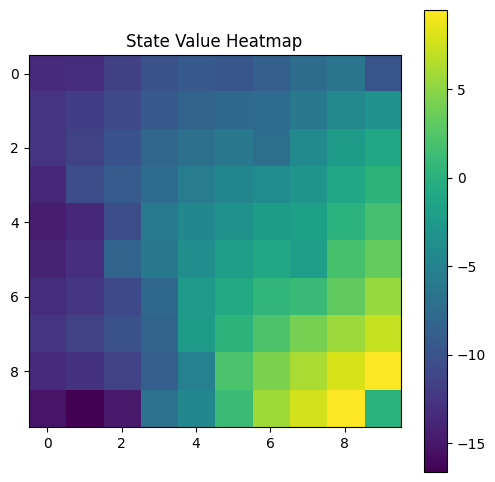

Policy Grid:
 [[np.str_('v') np.str_('v') 'H>' np.str_('>') np.str_('v') np.str_('>')
  np.str_('>') np.str_('v') 'Hv' 'H<']
 [np.str_('>') np.str_('>') np.str_('v') np.str_('>') np.str_('v') 'Hv'
  'H>' np.str_('>') np.str_('v') 'Hv']
 [np.str_('>') np.str_('>') np.str_('v') 'H>' np.str_('v') np.str_('v')
  'Hv' 'H>' np.str_('>') np.str_('v')]
 [np.str_('^') 'H>' np.str_('>') np.str_('>') np.str_('v') np.str_('v')
  'Hv' 'H>' np.str_('>') np.str_('v')]
 ['H^' np.str_('>') 'H^' 'H>' np.str_('>') np.str_('v') np.str_('v')
  np.str_('>') np.str_('>') np.str_('v')]
 ['H>' np.str_('>') 'H>' np.str_('>') np.str_('>') np.str_('v')
  np.str_('v') np.str_('<') 'H>' np.str_('v')]
 [np.str_('v') np.str_('v') 'H>' 'H^' 'H>' np.str_('>') np.str_('v') 'H>'
  np.str_('>') np.str_('v')]
 [np.str_('>') np.str_('>') np.str_('>') np.str_('>') 'H>' np.str_('>')
  np.str_('v') 'Hv' 'H>' np.str_('v')]
 [np.str_('^') 'H^' 'H^' 'H>' 'H>' 'H>' np.str_('>') np.str_('v')
  np.str_('v') np.str_('v')]
 ['H^' np.s

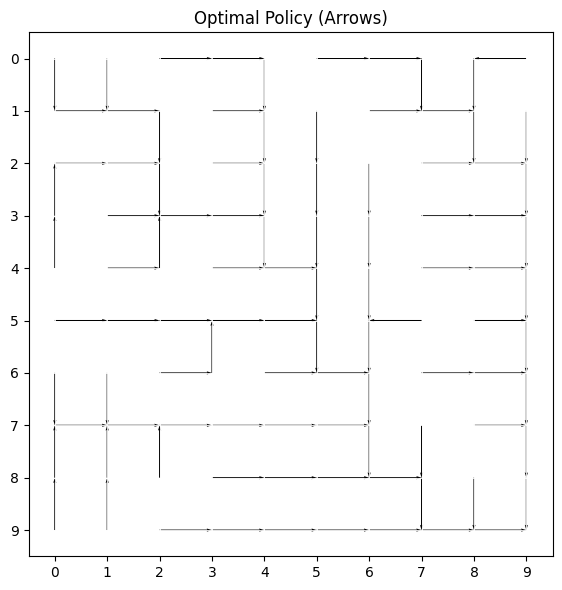

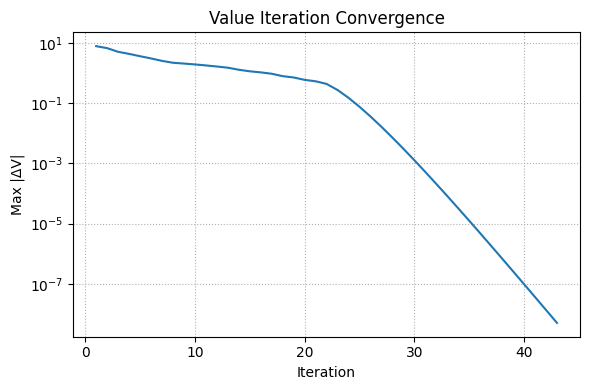

Rollout path: [(0, 0), (1, 0), (1, 1), (1, 2), (2, 2), (2, 3), (3, 3), (3, 4), (4, 4), (4, 5), (4, 4), (3, 4), (4, 4), (3, 4), (4, 4), (4, 5), (5, 5), (5, 6), (6, 6), (7, 6), (8, 6), (8, 7), (9, 7), (9, 8), (9, 9)]
Total return: -15.0


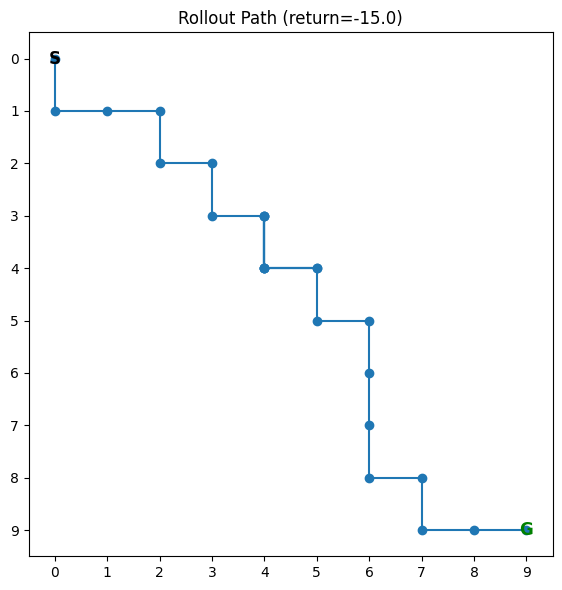

In [33]:
pi, V, deltas = value_iteration(P)

nS, nA = n_rows * n_cols, len(ACTIONS)
pi = np.asarray(pi)  # ensure numpy array
assert pi.ndim == 2 and pi.shape == (nS, nA), f"Expected pi shape {(nS, nA)}, got {pi.shape}. Recompute pi."
assert len(P) == nS, f"Transition model P has len {len(P)} != nS {nS}. Rebuild P."


plot_value_heatmap(V)
plot_policy_arrows(pi)
plot_policy_quiver(pi)
plot_convergence(deltas)

path, rewards = rollout(P, pi)
print("Rollout path:", path)
print("Total return:", sum(rewards))
plot_rollout_path(path, title=f"Rollout Path (return={sum(rewards):.1f})")